# Импорт библиотек и функций

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import re
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
import warnings
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
warnings.filterwarnings('ignore')

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
try:
  toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
except:
  toxic_comments = pd.read_csv('/content/toxic_comments.csv')

In [ ]:
toxic_comments.info()
toxic_comments.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
22103,22123,what up chink \n\nwackpedia admins are faggots...,1
24681,24704,NCAA vacated games \nFYI. The NCAA record book...,0


In [ ]:
print('Кол-во явных дубликатов',toxic_comments.duplicated().sum())

Кол-во явных дубликатов 0


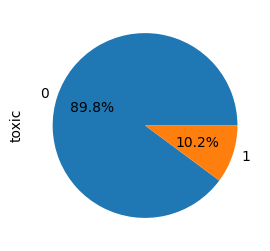

In [ ]:
toxic_comments['toxic'].value_counts().plot(kind='pie',autopct='%0.1f%%',figsize=(3,3));

- столбец 'Unnamed: 0' дублирует индексы таблицы, решено убрать из расмотрения
- таблица соответствует описанию данных
- отсутствуют пропуски и дубликаты в таблице
- несбаланированы классы в целевом признаке, решено использовать стратификацию и сбалансированные классы
- текст сообщений написан на английском языке, решено использовать при подготовке данных стоп-слова английского словаря

In [ ]:
df = toxic_comments.drop(['Unnamed: 0'], axis=1)

In [ ]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None
    sentence = text
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [ ]:
def clear_text(text):
    text=re.sub(r'[^a-zA-Z ]', ' ', text)
    text=" ".join(text.split())
    return text

In [ ]:
text_lemm = np.array(df.loc[:,'text'])
vect_clear = np.vectorize(clear_text)
text_lemm = vect_clear(text_lemm)
vect_lemm = np.vectorize(lemmatize)
text_lemm = vect_lemm(text_lemm)
df['text'] = text_lemm
df.info()
df.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
145062,You ve be quite about the merger for day That ...,0
71393,I understand you would like me to share info o...,0


**Вывод по разделу:**

- подготовлены данные для обучения модели, проведена очистка текста от пунктуации и леммантизация

## Обучение

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['toxic'],
                                                    random_state=42,
                                                    train_size=0.9)

- проведено разделение данных на тренировочную и тестовую выборку с стратификацией по целевому признаку

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words='english')
X_train = count_tf_idf.fit_transform(X_train)
X_test = count_tf_idf.transform(X_test)
print("Размер матрицы:", X_train.shape)

Размер матрицы: (143362, 150998)


- подготовлены данные для обучения модели, кол-во записей = 143362, кол-во признаков = 150988

**Модель LogisticRegression**

In [ ]:
%%time
params = {
    'C' : [1, 0.1, 0.01, 10, 100, 1000]
}

model_lr = RandomizedSearchCV(estimator=LogisticRegression(class_weight='balanced',random_state=42),
                              scoring='f1', param_distributions=params, cv=4, n_iter=6, n_jobs=-1)
model_lr.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', model_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', model_lr.best_score_)

Лучшая модель и её параметры:

 LogisticRegression(C=10, class_weight='balanced', random_state=42)
Метрика лучшей модели на тренировочной выборке: 0.7602578957578626
CPU times: user 11.5 s, sys: 12.1 s, total: 23.6 s
Wall time: 1min 58s


**Модель DecisionTreeClassifier**

In [ ]:
%%time
params = {}

model_dtc = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=42),
                              scoring='f1', param_distributions=params, cv=4, n_iter=1, n_jobs=-1)
model_dtc.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', model_dtc.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', model_dtc.best_score_)

Лучшая модель и её параметры:

 DecisionTreeClassifier(class_weight='balanced', random_state=42)
Метрика лучшей модели на тренировочной выборке: 0.6544516471020394
CPU times: user 3min 58s, sys: 1.22 s, total: 4min
Wall time: 13min 5s


**Анализ на тестовой выборке**

In [ ]:
predictions = model_lr.predict(X_test)
f1 =  f1_score(y_test, predictions)
print("Модель LogisticRegression f1 = ", f1)

Модель LogisticRegression f1 =  0.7660311958405547


**Вывод по разделу**

- анализ метрик f1 выбранных моделей показал, что модель логической регресии соответсвует ТЗ заказчика (f1>0.75)

## Выводы

В данной работе были обучены 2 модели для классификации комментариев на позитивные и негативные.

Данные были получены из следующего файла /datasets/toxic_comments.csv. Перед началом обучения моделей был произведен обзор и проверка на адекватность полученных данных. Выявлено, что:

- столбец 'Unnamed: 0' дублирует индексы таблицы, решено убрать из расмотрения
- таблица соответствует описанию данных
- отсутствуют пропуски и дубликаты в таблице
- несбаланированы классы в целевом признаке, решено использовать стратификацию и сбалансированные классы
- текст сообщений написан на английском языке, решено использовать при подготовке данных стоп-слова английского словаря

Промежуточный этап подготовки данных показал, что:

- подготовлены данные для обучения модели, проведена очистка текста от пунктуации и леммантизация

В рамках обучения были использованы модели LogisticRegression и DecisionTreeClassifier:

- подготовлены данные для обучения модели, кол-во записей = 143362, кол-во признаков = 150988
- проведено разделение данных на тренировочную и тестовую выборку
- анализ метрик f1 выбранных моделей показал, что модель логической регресии соответсвует ТЗ заказчика (f1>0.75)